<a href="https://colab.research.google.com/github/CristylePGarrard/ElectionTime/blob/main/legislative_branch_kpi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
# I want to create a kpi dashboard for candidates that are running again for the same office

# ####### Install necessary libraries ####### #
!pip install gspread gspread-dataframe pandas openpyxl squarify wordcloud

# ####### Import libraries ####### #
import pandas as pd
import gspread
from gspread_dataframe import get_as_dataframe
from google.colab import auth
from googleapiclient.discovery import build
import squarify
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Pull Data

In [2]:
# ################################################### #
# ####### pull in the data for the candidates ####### #
# ################################################### #

# ####### Mount Google Drive to Colab ####### #
from google.colab import drive
drive.mount('/content/drive')

# ####### Set the file path to uploaded Excel file ####### #
# Update the path with the actual location of file in Google Drive
file_path = '/content/drive/My Drive/ut_pol/'
filename = 'cleaned_candidates_data.csv'

# ####### Read the Excel file into a DataFrame ####### #
print("Reading Excel file...")

# There's a weird warning about the format and openpyxl but we don't gotta worry about that so ignore it
import warnings
warnings.simplefilter("ignore")

# Read the Excel file
candidates = pd.read_csv(file_path+filename)

# There are 2 types of candidates running for office in the legislative branch
# Those that have been in office and are running again (incumbent)
# And those who are running to be in office the first time.
# Let's just look at the incumbents and see what legislation they've sponsored and whether it's passed or not passed

# don't need all the info right now
include_columns = ['Name on Ballot', 'First Name', 'Middle Name',
                   'Last Name', 'Office', 'District', 'Party',
                   'Status','Display District', 'record_id', 'Incumbent']
candidates = candidates[include_columns].copy()

# only need candidates that are running again
include_status = ['Election Candidate', 'Write-In']
candidates = candidates.loc[candidates['Status'].isin(include_status)].copy().reset_index(drop=True)

# only look at incumbent candidates
candidates = candidates.loc[candidates['Incumbent'] == True].copy().reset_index(drop=True)
# only look at State House & State Senate
candidates = candidates.loc[candidates['Office'].isin(['State House', 'State Senate'])].copy().reset_index(drop=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading Excel file...


In [3]:
# #################################################################### #
# ####### pull in the data for the bills that have been passed ####### #
# #################################################################### #

bills_file_path = '/content/drive/My Drive/ut_pol/passedBills/'

list_of_bills = os.listdir(bills_file_path)
# print(list_of_bills)

all_data = []

for f in list_of_bills:
  if f.endswith('.csv'):
    temp = pd.read_csv(bills_file_path + f)
    temp['sheet_name'] = f
    all_data.append(temp)

bills = pd.concat(all_data, axis=0, ignore_index=True)

# print(bills.head())

# we only need data for 2021 - 2024
bills['Year'] = bills['sheet_name'].str.extract(r'(\d{4})')
bills = bills.loc[bills['Year'].isin(['2021', '2022', '2023', '2024'])].copy().reset_index(drop=True)

# make sure dtypes are correct
bills['Date Passed'] = pd.to_datetime(bills['Date Passed'], errors='coerce')
bills['Effective Date'] = pd.to_datetime(bills['Effective Date'], errors='coerce')
bills['Gov\'s Action Date'] = pd.to_datetime(bills['Gov\'s Action Date'], errors='coerce')
bills['Year'] = bills['Year'].astype(int)

# What to do when the gov's action is empty

bills['Governor\'s Action'].unique()

bills.loc[bills['Governor\'s Action'].isnull()]

# Replace null values in the 'Governor's Action' column with 'no value'
bills['Governor\'s Action'] = bills['Governor\'s Action'].fillna('NO VALUE').copy().reset_index(drop=True)

# Merge Data

In [4]:
# 1st merge the two dataframes together
# Extracting last name and first initial from Bill Sponsor in the bills dataframe
bills['Last Name'] = bills['Bill Sponsor'].apply(lambda x: x.split(', ')[0])
bills['First Initial'] = bills['Bill Sponsor'].apply(lambda x: x.split(', ')[1][0] if len(x.split(', ')) > 1 else '')

# Create a column to match with candidates by concatenating Last Name and First Initial
bills['Sponsor Key'] = bills['Last Name'] + ' ' + bills['First Initial']

# In the candidates dataframe, create a key column to match with bills
candidates['First Initial'] = candidates['First Name'].str[0]  # Get the first initial
candidates['Candidate Key'] = candidates['Last Name'] + ' ' + candidates['First Initial']

merged_df = pd.merge(candidates, bills, left_on='Candidate Key', right_on='Sponsor Key', how='left')


In [5]:
# Which candidates sponsored no bills?

print(merged_df.loc[merged_df['Bill Number'].isna()]['Name on Ballot'].unique())

['MATT MACPHERSON']


# Create Categories

In [6]:
# Categories targeting keywords in the bills.

categories = {
    'Education': ['higher education',
                  'juvenile',
                  'school',
                  'university',
                  'student',
                  'education',
                  'students',
                  'teacher',
                  'educator',
                  'learning',
                  'academic',
                  'college',
                  'preschool',
                  'daycare',
                  'scholarship',
                  'training',
                  'literacy',
                  'diploma',
                  'certification',
                  'tutoring',
                  'virtual learning',
                  'STEM',
                  'vocational'],
    'Healthcare': ['health',
                   'medical',
                   'hospital',
                   'healthcare',
                   'wellness',
                   'doctor',
                   'nurse',
                   'patient',
                   'mental health',
                   'therapy',
                   'pharmacy',
                   'perscription',
                   'medication',
                   'vaccination',
                   'clinic',
                   'public health',
                   'emergency care',
                   'Medicare',
                   'Medicaid',
                   'telehealth',
                   'nutrition',
                   'fitness',
                   'insurance',
                   'coverage',
                   'healthcare plan',
                   'health policy',
                   'ACA',
                   'Affordable Care Act'],
    'Environment': ['wildlife',
                    'conservation',
                    'climate',
                    'public lands',
                    'water',
                    'land',
                    'energy',
                    'federal lands',
                    'national parks',
                    'parks',
                    'air pollution',
                    'pollution',
                    'sustainability',
                    'renewable energy',
                    'solar energy',
                    'wind',
                    'emissions',
                    'recycling',
                    'green energy',
                    'forest',
                    'nature',
                    'ecosystem',
                    'habitat',
                    'compost',
                    'natural resources',
                    'clean energy',
                    'biodiversity',
                    'plastic',
                    'river',
                    'lakes'],
   'Transportation': ['vehicle',
                       'access',
                       'road',
                       'bridge',
                       'infrastructure',
                       'transport',
                       'transportation',
                       'bus',
                       'train',
                       'airport',
                       'traffic',
                       'aviation',
                       'trax',
                       'rail',
                       'pedestrain',
                       'carpool',
                       'ride-sharing',
                       'electric vehicles'
                       'EVs',
                       'public transport'],
    'Economy & Business': ['economy',
                           'business',
                           'trade',
                           'investment',
                           'budget',
                           'entrepreneurship',
                           'startup',
                           'small business',
                           'marketplace',
                           'labor',
                           'jobs',
                           'fiscal',
                           'profit',
                           'consumer',
                           'regulation',
                           'commerce',
                           'fiscal',
                           'profit',
                           'deficit',
                           'tariffs',
                           'inflation',
                           'recession',
                           'workforce',
                           'job',
                           'employment',
                           'union',
                           'wages',
                           'worker',
                           'employee rights',
                           'unemployment',
                           'job training',
                           'occupational safety',
                           'minimum wage',
                           'retirement',
                           'labor market',
                           'workforce development',
                           'apprenticeship',
                           'hiring',
                           'strike',
                           'workplace',
                           'layoff',
                           'gig economy'],
    'Housing': ['housing',
                'rent',
                'mortgage',
                'zoning',
                'landlort',
                'tenant',
                'real estate',
                'property',
                'affordable housing',
                'homelessness',
                'apartment',
                'condo',
                'homeownership',
                'shelter',
                'building',
                'construction',
                'dwelling',
                'housing assistance',
                'housing',
                'subsidy',
                'redevelopment',
                'residential',
                'vacancy',
                'land use'],
    'Civil Rights & Justice': ['rights',
                               'justice',
                               'equality',
                               'discrimination',
                               'court',
                               'civil liberties',
                               'human rights',
                               'diversity',
                               'equity',
                               'inclusion',
                               'immigration',
                               'refugee',
                               'gender equality',
                               'racial justice',
                               'indigenous rights',
                               'advocacy',
                               'legal aid',
                               'prison reform'],
    'Veteran Services': ['veteran services',
                         'veteran',
                         'veterans'],
    'Technology & Innovation':['tech',
                               'innovation',
                               'digital',
                               'cybersecurity',
                               'cyper',
                               'artificial intelligence',
                               'AI',
                               'automation',
                               'data',
                               'software',
                               'IT',
                               'blockchain',
                               'fintech',
                               'apps',
                               'encryption',
                               'robotocs',
                               'e-commerce',
                               'virtual',
                               'connectivity',
                               'online privacy',
                               'online',
                               'FTC',
                               'KOSA',
                               'web browsser',
                               'web security',
                               'VPN',
                               'privacy',
                               'data broker',
                               'biometric'],
    'Agriculture & Food': ['agriculture',
                           'farm',
                           'food',
                           'crop',
                           'livestock',
                           'raching',
                           'fisheries',
                           'dairy',
                           'aquaculture',
                           'pesticide',
                           'organic',
                           'GMO',
                           'seeds',
                           'soil',
                           'food safety',
                           'farmers market',
                           'farming practices',
                           'food security',
                           'nutrition',
                           'climate-resilient crops',
                           'rural',
                           'irrigation',
                           'harvest'],
    'Energy': ['oil',
               'gas',
               'power',
               'electriciy',
               'fossil fuels',
               'wind',
               'solar',
               'renewable energy',
               'geothermal',
               'energy efficiency',
               'power grid',
               'pipeline',
               'nuclear energy',
               'drilling',
               'fracking',
               'fuel',
               'decarbonization',
               'carbon capture',
               'coal',
               'natural gas',
               'utility',
               'hydroelectric'],
    'Government & Administration': ['government',
                                    'administration',
                                    'policy',
                                    'regulation',
                                    'election',
                                    'legislature',
                                    'governance',
                                    'public service',
                                    'ammendment',
                                    'resolution',
                                    'agency',
                                    'budget',
                                    'transparency',
                                    'bureaucracy',
                                    'civic',
                                    'oversight',
                                    'reform',
                                    'accountability',
                                    'budget',
                                    'public service',
                                    'department',
                                    'referendum',
                                    'municipal',
                                    'liscensing',
                                    'code',
                                    'rules',
                                    'requirements',
                                    'fund',
                                    'appropriations',
                                    'budget',
                                    'tax',
                                    'revenue',
                                    'income',
                                    'finance'],
    'Military & Defense': ['military',
                           'defense',
                           'armed forces',
                           'national guard',
                           'security',
                           'homeland',
                           'military service',
                           'deployment',
                           'affairs',
                           'defense spending',
                           'weapons',
                           'strategy',
                           'military base',
                           'combat',
                           'enlistment',
                           'war',
                           'intelligence',
                           'protection',
                           'national security',
                           'reserves',
                           'peacekeeping'],
}

def categorize_bill(title):
    title = title.lower()  # convert title to lowercase for easier matching
    for category, keywords in categories.items():
        for keyword in keywords:
            if keyword in title:
                return category
    return 'Other'  # If no category matches, return 'Other'

# error when running because there is an incumbent who did not sponsor any bills.
merged_df['Bill Title'] = merged_df['Bill Title'].fillna('No Title Provided')

merged_df['Category'] = merged_df['Bill Title'].apply(categorize_bill)

print(merged_df[['Bill Title', 'Category']].head())

                               Bill Title    Category
0     Law Enforcement Officer Amendments        Other
1            Medical Cannabis Amendments   Healthcare
2                      Inmate Amendments        Other
3  Children's Health Coverage Amendments   Healthcare
4     Charitable Contribution Amendments        Other


In [7]:
# before = merged_df.groupby('Category').count()['Bill Number'].sort_values(ascending=False)

In [8]:
# after = merged_df.groupby('Category').count()['Bill Number'].sort_values(ascending=False)
# diff = after - before
# print(diff)

In [9]:
# print(before)
# print(after)

In [10]:
print(merged_df.groupby('Category').count()['Bill Number'].sort_values(ascending=False))
print(merged_df.Category.unique())

Category
Other                          453
Education                      161
Government & Administration    141
Environment                    106
Transportation                  96
Housing                         93
Healthcare                      77
Economy & Business              59
Technology & Innovation         25
Military & Defense              21
Civil Rights & Justice          17
Agriculture & Food              16
Energy                           7
Name: Bill Number, dtype: int64
['Other' 'Healthcare' 'Education' 'Agriculture & Food'
 'Government & Administration' 'Environment' 'Housing'
 'Technology & Innovation' 'Transportation' 'Economy & Business'
 'Civil Rights & Justice' 'Military & Defense' 'Energy']


# Functions

In [19]:
# IMPORT LIBRARIES
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.patches as patches
import squarify
import matplotlib.dates as mdates

In [20]:
def create_directory(path):
  if 'os' not in dir():
    import os

  if not os.path.exists(path):
    os.makedirs(path)

In [21]:
def save_candidate_chart(fig, office, candidate_name, chart_type, initial_drive_path, print_info=False):

  # make foler if not there for where to save files
  office_folder = os.path.join(initial_drive_path, office)
  create_directory(office_folder)

  # filename
  save_name_as = candidate_name.replace(" ", "_")
  file_name = f'{save_name_as}_{chart_type}.png'
  file_path = os.path.join(office_folder, file_name)

  # save chart
  fig.savefig(file_path, bbox_inches='tight', dpi=300)

  if print_info:
    print(f"Chart saved to {file_path}")


In [22]:
def bar_chart_gov_actions(df, name_on_ballot, color_map, print_info=False, show_chart=False, save_chart=False):

  if 'plt' not in dir():
    import matplotlib.pyplot as plt


  if df.loc[df['Name on Ballot'] == name_on_ballot].empty:
    print(f"No data found for {name_on_ballot}")
    return

  if df.loc[(~df['Bill Number'].isna()) & (df['Name on Ballot'] == name_on_ballot)].empty:
      print(f"No bills found for {name_on_ballot}")
      return

  candidate_bills = df[df['Name on Ballot'] == name_on_ballot]
  action_counts = candidate_bills['Governor\'s Action'].value_counts()
  display_district = candidate_bills['Display District'].iloc[0] if not candidate_bills.empty else "N/A"
  total_bills = len(candidate_bills)
  candidate_name = " ".join([x.capitalize() for x in name_on_ballot.split()])
  office = candidate_bills['Office'].iloc[0] if not candidate_bills.empty else "N/A"

  fig, ax = plt.subplots(figsize=(8, 6))

  action_counts.plot(kind='bar',
                     ax=ax,
                     color=[color_map.get(action, 'black') for action in action_counts.index],
                     alpha=0.7)

  ax.set_xlabel('')
  ax.set_ylabel('Count of Bills')
  ax.set_title(f"Bills sponsored by {candidate_name}\n"
               f"State Senate {display_district}\n"
               f"Total number of bills sponsored = {total_bills}", fontsize=14)

  ax.set_xticklabels(action_counts.index, rotation=0, ha='center')

  plt.tight_layout()

  if save_chart:
    save_candidate_chart(fig, office, candidate_name, "bar_chart", base_drive_path)

  if print_info:
    print(f"Bar Chart for {candidate_name} in {display_district} has been created with {total_bills} bills.")

  if show_chart:
    plt.show()
  else:
    plt.close(fig)


In [41]:
def timeline_gov_actions(df, name_on_ballot, color_map, show_chart=False, print_info=False, save_chart=False):

  if 'plt' not in dir():
    import matplotlib.pyplot as plt

  if 'mdates' not in dir():
    import matplotlib.dates as mdates

  if 'calendar' not in dir():
    from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

  if df.loc[df['Name on Ballot'] == name_on_ballot].empty:
    print(f"No data found for {name_on_ballot}")
    return

  if df.loc[(~df['Bill Number'].isna()) & (df['Name on Ballot'] == name_on_ballot)].empty:
      print(f"No bills found for {name_on_ballot}")
      return

  candidate_bills = df[df['Name on Ballot'] == name_on_ballot]
  candidate_name = " ".join([x.capitalize() for x in name_on_ballot.split()])
  display_district = candidate_bills['Display District'].iloc[0] if not candidate_bills.empty else "N/A"
  total_bills = len(candidate_bills)
  candidate_name = " ".join([x.capitalize() for x in candidate.split()])
  office = candidate_bills['Office'].iloc[0] if not candidate_bills.empty else "N/A"

  candidate_bills['Date Passed'] = pd.to_datetime(candidate_bills['Date Passed'])
  timeline_data = candidate_bills.groupby(['Date Passed', 'Governor\'s Action']).size().unstack(fill_value=0)
  fig, ax = plt.subplots(figsize=(8, 6))

  for action in timeline_data.columns:
      ax.plot(timeline_data.index, timeline_data[action],
              label=action,
              marker='o',
              color=color_map.get(action, 'black'))  # Default to black if action not in map

  ax.set_title(f"Timeline Bills Sponsored by {candidate_name}", fontsize=14)
  ax.set_ylabel("Count of Actions")
  ax.set_xlabel("")
  ax.legend(title='Governor\'s Action', loc='upper right', fontsize=8)
  ax.grid(True, linestyle='--', alpha=0.7)

  ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Shows month and year

  # Highlighting the General and Special sessions
  # Calculate sessions for each year present in the data
  years = candidate_bills['Date Passed'].dt.year.unique()

  for year in years:
      # Find the fourth Monday in January
      january_first = pd.to_datetime(f"{year}-01-01")
      fourth_monday = january_first + pd.DateOffset(days=(3 - january_first.weekday() + 28) % 7)
      general_session_end = fourth_monday + timedelta(days=45)

      print(fourth_monday, general_session_end)
      # Highlight the General Session period
      ax.axvspan(fourth_monday, general_session_end,
                  color='lightgray', alpha=0.3, label='General Session' if year == years.min() else "")

      # Highlight the periods outside of the General Session as Special Session
      if year == years.min():
          ax.axvspan(pd.to_datetime(f"{year}-01-01"), fourth_monday,
                      color='lightblue', alpha=0.3, label='Special Session')
      else:
          ax.axvspan(pd.to_datetime(f"{year}-01-01"), fourth_monday,
                      color='lightblue', alpha=0.3)

      ax.axvspan(general_session_end, pd.to_datetime(f"{year}-12-31"),
                  color='lightblue', alpha=0.3)

  # Remove duplicate labels in the legend
  handles, labels = ax.get_legend_handles_labels()
  unique_labels = dict(zip(labels, handles))
  ax.legend(unique_labels.values(), unique_labels.keys(), title='Governor\'s Action', loc='upper right', fontsize=8)


  plt.tight_layout()
  plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

  if print_info:
    print(f"timeline Chart for {candidate_name} in {display_district} has been created with {total_bills} bills.")

  if save_chart:
    save_candidate_chart(fig, office, candidate_name, "timeline", base_drive_path)

  if show_chart:
    plt.show()
  else:
    plt.close(fig)



In [24]:
def treemap_bill_categories(df, name_on_ballot, color_map, print_info=False, save_chart=False, show_chart=False):

  if 'plt' not in dir():
    import matplotlib.pyplot as plt

  if 'squarify' not in dir():
    import squarify

  if df.loc[df['Name on Ballot'] == name_on_ballot].empty:
    print(f"No data found for {name_on_ballot}")
    return

  if df.loc[(~df['Bill Number'].isna()) & (df['Name on Ballot'] == name_on_ballot)].empty:
      print(f"No bills found for {name_on_ballot}")
      return

  candidate_bills = df[df['Name on Ballot'] == name_on_ballot]
  candidate_name = " ".join([x.capitalize() for x in name_on_ballot.split()])
  display_district = candidate_bills['Display District'].iloc[0] if not candidate_bills.empty else "N/A"
  total_bills = len(candidate_bills)
  candidate_name = " ".join([x.capitalize() for x in candidate.split()])
  office = candidate_bills['Office'].iloc[0] if not candidate_bills.empty else "N/A"

  # count the number of bills in each category
  category_counts = df['Category'].value_counts().reset_index()
  category_counts.columns = ['Category', 'Count']

  sizes = category_counts['Count']
  labels = category_counts['Category']

  # color_palette = plt.cm.Set3.colors[:len(labels)]  # Use the same colormap as before
  colors = [color_map.get(category, '#7DFFFF') for category in labels]

  fig, ax = plt.subplots(figsize=(8, 6))

  # Draw the treemap without labels
  squarify.plot(sizes=sizes,
              ax=ax,
              alpha=0.7,
              color=colors,
              bar_kwargs={'linewidth': 2, 'edgecolor': 'white'})

  ax.set_title(f"{name_on_ballot} Bills by Category\n"
                f"State Senate {display_district}\n"
                f"Total number of bills sponsored = {total_bills}", fontsize=14)

  ax.axis('off')

  # Create a legend to map colors to categories
  handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[category])
           for category in labels if category in color_map]
  ax.legend(handles, labels, title='Categories', loc='upper center', bbox_to_anchor=(0.5, -0.05), ncols=3, fontsize=10)

  plt.subplots_adjust(top=0.9, bottom=0.1, right=1)  # Adjust the bottom value as needed
  plt.tight_layout()

  if print_info:
    print(f"Treemap Chart for {candidate_name} in {display_district} has been created with {total_bills} bills.")

  if save_chart:
    save_candidate_chart(fig, office, candidate_name, "treemap", base_drive_path)

  if show_chart:
    plt.show()
  else:
    plt.close(fig)


In [25]:
def wordcloud_bill_titles(df, name_on_ballot, color_map, num_words, base_drive_path, show_chart=False, print_info=False, save_chart=False):

  if 'plt' not in dir():
    import matplotlib.pyplot as plt

  if 'WordCloud' not in dir():
    from wordcloud import WordCloud

  if 'patches' not in dir():
    import matplotlib.patches as patches

  if df.loc[df['Name on Ballot'] == name_on_ballot].empty:
    print(f"No data found for {name_on_ballot}")
    return

  if df.loc[(~df['Bill Number'].isna()) & (df['Name on Ballot'] == name_on_ballot)].empty:
      print(f"No bills found for {name_on_ballot}")
      return

  candidate_bills = df[df['Name on Ballot'] == name_on_ballot]
  candidate_name = " ".join([x.capitalize() for x in name_on_ballot.split()])
  display_district = candidate_bills['Display District'].iloc[0] if not candidate_bills.empty else "N/A"
  total_bills = len(candidate_bills)
  candidate_name = " ".join([x.capitalize() for x in candidate.split()])
  office = candidate_bills['Office'].iloc[0] if not candidate_bills.empty else "N/A"

  # Get the titles of the bills for the current candidate
  bill_titles = candidate_bills['Bill Title'].fillna('')  # Replace NaN with an empty string

  # Combine all titles into a single text blob for the word cloud
  text_blob = ' '.join(bill_titles)

  # Generate a word cloud
  wordcloud = WordCloud(
      width=800,
      height=400,
      background_color='white',
      colormap=color_map,  # other colormaps like viridis & plasma
      max_words=num_words,  # Limit the number of words displayed
      random_state=42 # Ensures consistent results across runs
      ).generate(text_blob)

  # Plot the word cloud with a border
  fig, ax = plt.subplots(figsize=(8, 6))
  ax.imshow(wordcloud, interpolation='bilinear')
  ax.axis('off')  # Hide the axes for better visual appeal
  ax.set_title(f"Word Cloud of Bill Titles Sponsored by {name_on_ballot}", fontsize=14)

  # Add a border around the word cloud
  rect = patches.Rectangle(
      (0, 0), 1, 1, transform=ax.transAxes,
      linewidth=2, edgecolor='black', facecolor='none'
  )
  ax.add_patch(rect)

  plt.tight_layout()

  if print_info:
      print(f"Wordcloud Chart for {candidate_name} in {display_district} has been created with {total_bills} bills.")

  if save_chart:
    save_candidate_chart(fig, office, candidate_name, "word_cloud", base_drive_path)

  if show_chart:
    plt.show()
  else:
    plt.close(fig)


# Charts



*****************************
Looping through State House
*****************************
*****************************
Looping through State Senate
*****************************
2023-01-05 00:00:00 2023-02-19 00:00:00
2022-01-06 00:00:00 2022-02-20 00:00:00
2021-01-07 00:00:00 2021-02-21 00:00:00
2024-01-04 00:00:00 2024-02-18 00:00:00


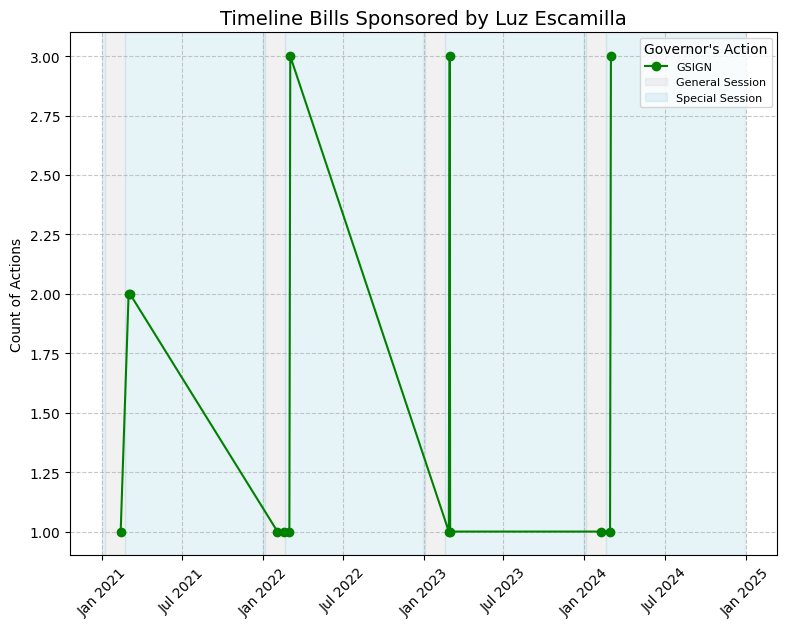

2023-01-05 00:00:00 2023-02-19 00:00:00
2022-01-06 00:00:00 2022-02-20 00:00:00
2021-01-07 00:00:00 2021-02-21 00:00:00
2024-01-04 00:00:00 2024-02-18 00:00:00


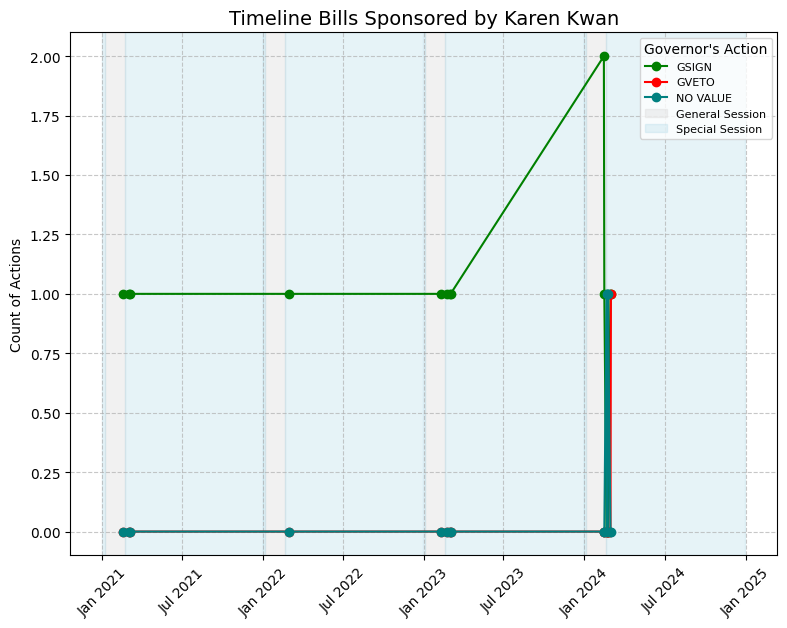

2023-01-05 00:00:00 2023-02-19 00:00:00
2022-01-06 00:00:00 2022-02-20 00:00:00
2021-01-07 00:00:00 2021-02-21 00:00:00
2024-01-04 00:00:00 2024-02-18 00:00:00


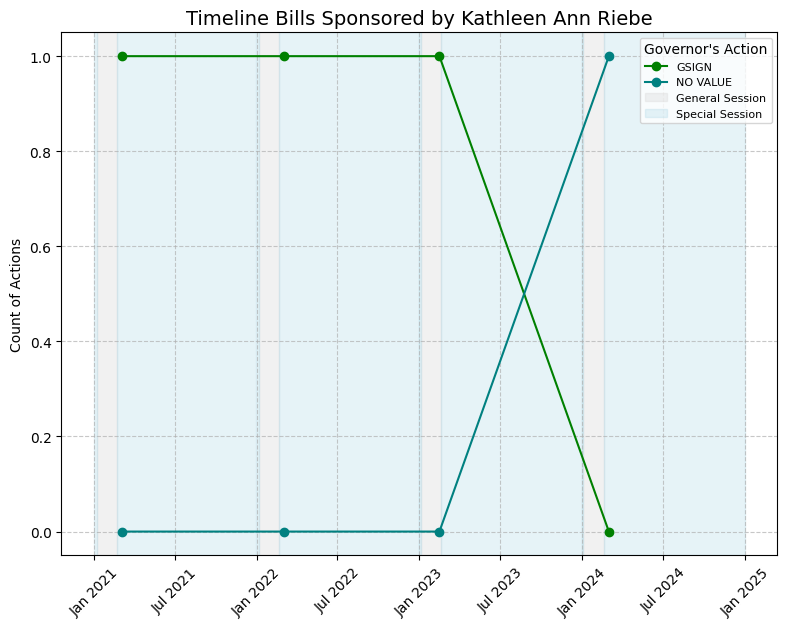

2023-01-05 00:00:00 2023-02-19 00:00:00
2022-01-06 00:00:00 2022-02-20 00:00:00
2021-01-07 00:00:00 2021-02-21 00:00:00
2024-01-04 00:00:00 2024-02-18 00:00:00


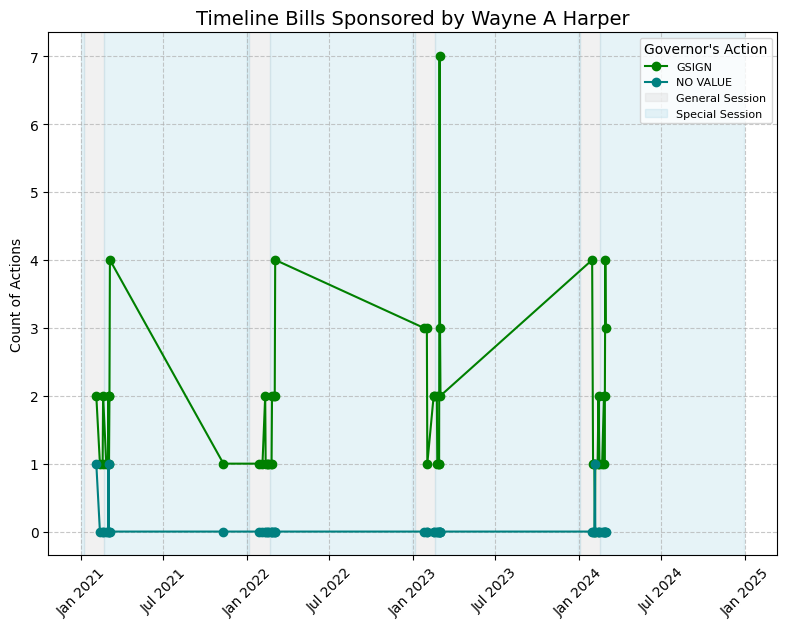

2023-01-05 00:00:00 2023-02-19 00:00:00
2022-01-06 00:00:00 2022-02-20 00:00:00
2021-01-07 00:00:00 2021-02-21 00:00:00
2024-01-04 00:00:00 2024-02-18 00:00:00


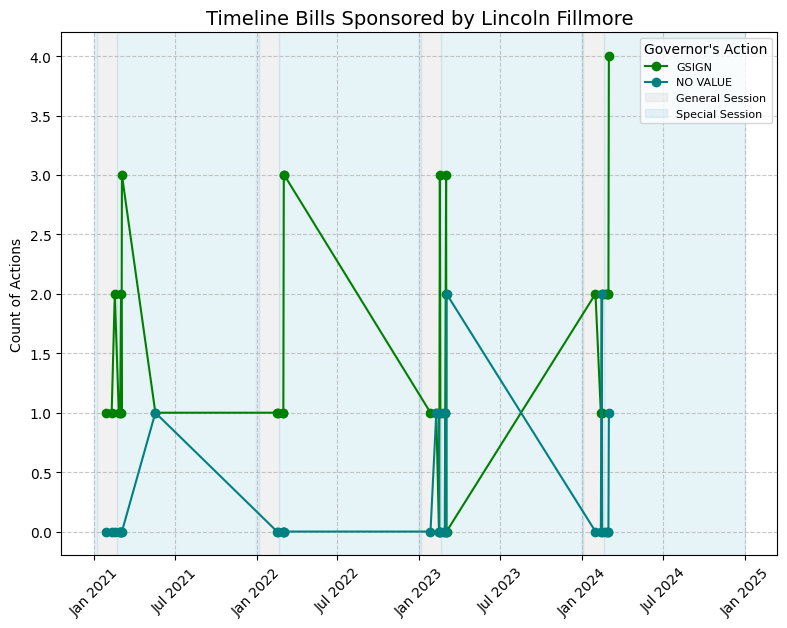

2023-01-05 00:00:00 2023-02-19 00:00:00
2022-01-06 00:00:00 2022-02-20 00:00:00
2021-01-07 00:00:00 2021-02-21 00:00:00
2024-01-04 00:00:00 2024-02-18 00:00:00


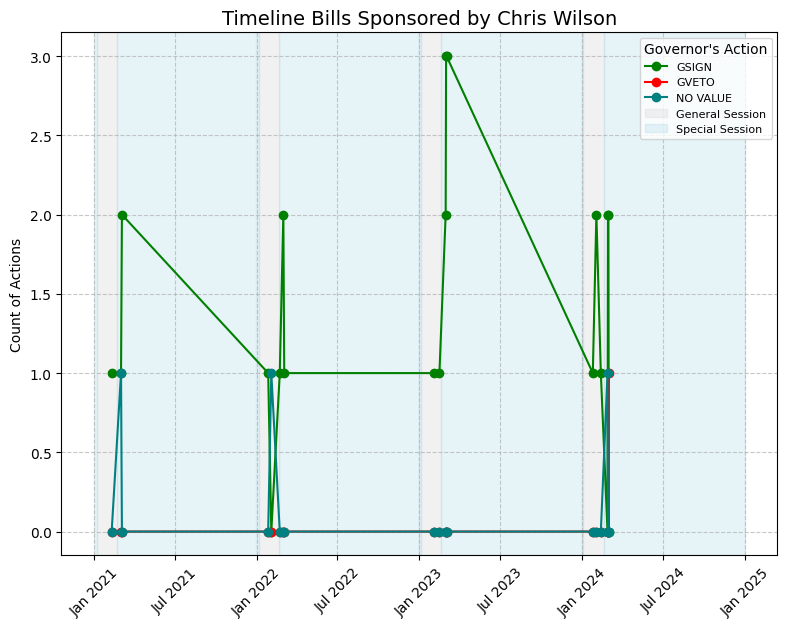

2024-01-04 00:00:00 2024-02-18 00:00:00


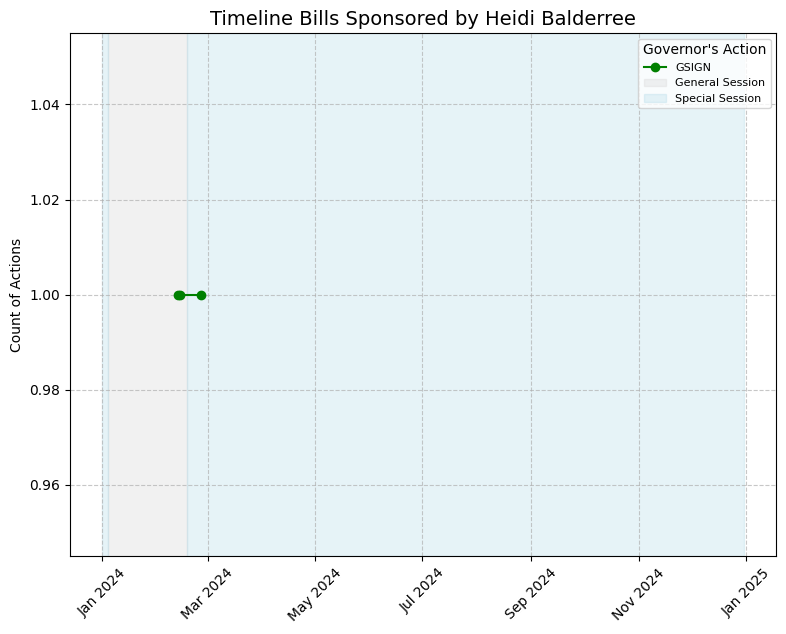

2023-01-05 00:00:00 2023-02-19 00:00:00
2022-01-06 00:00:00 2022-02-20 00:00:00
2021-01-07 00:00:00 2021-02-21 00:00:00
2024-01-04 00:00:00 2024-02-18 00:00:00


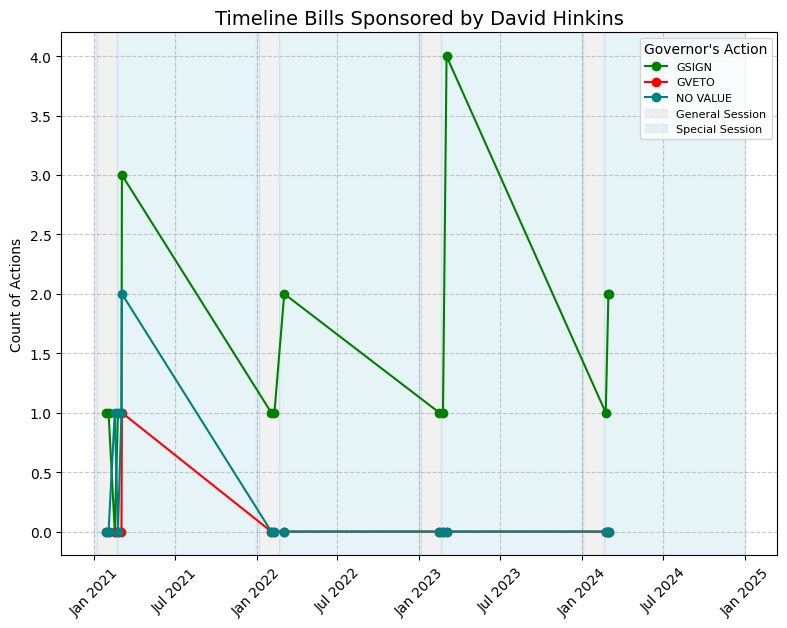

2023-01-05 00:00:00 2023-02-19 00:00:00
2022-01-06 00:00:00 2022-02-20 00:00:00
2021-01-07 00:00:00 2021-02-21 00:00:00
2024-01-04 00:00:00 2024-02-18 00:00:00


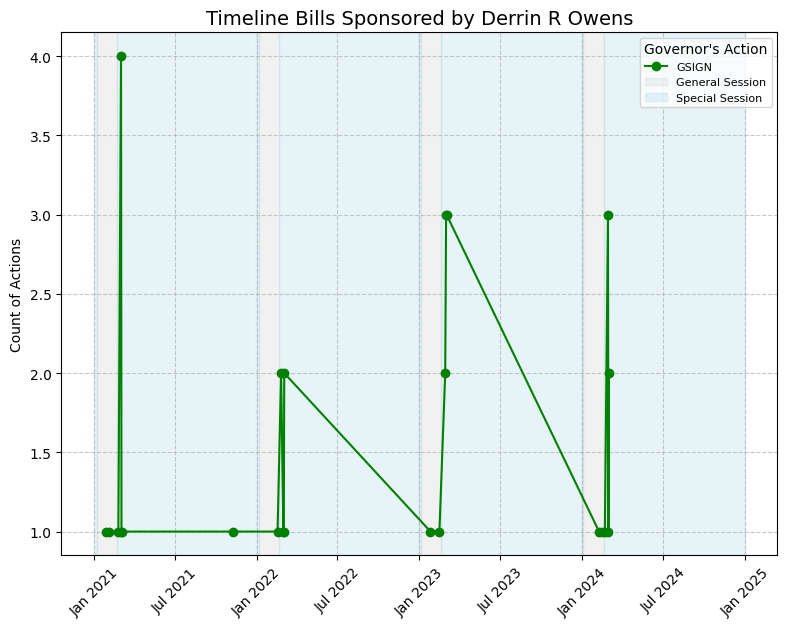

2023-01-05 00:00:00 2023-02-19 00:00:00
2022-01-06 00:00:00 2022-02-20 00:00:00
2021-01-07 00:00:00 2021-02-21 00:00:00
2024-01-04 00:00:00 2024-02-18 00:00:00


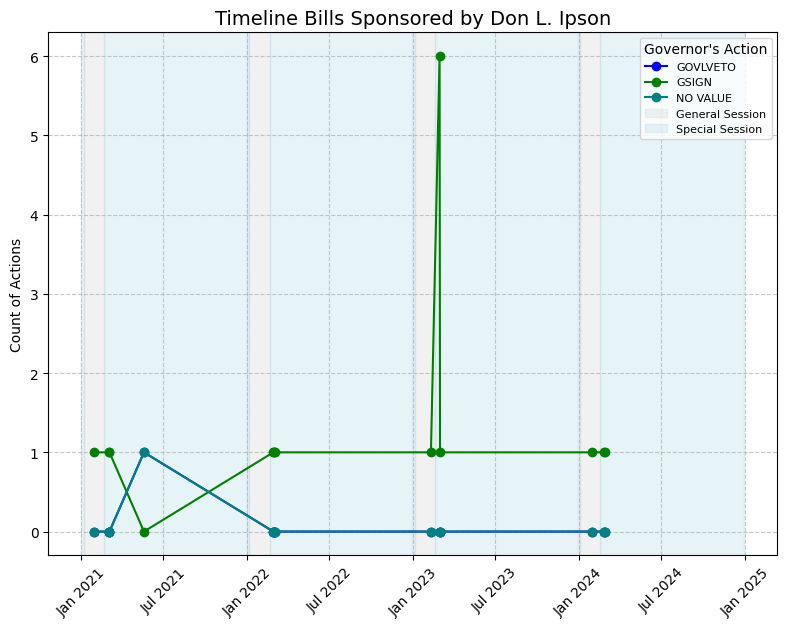

2023-01-05 00:00:00 2023-02-19 00:00:00
2022-01-06 00:00:00 2022-02-20 00:00:00
2021-01-07 00:00:00 2021-02-21 00:00:00
2024-01-04 00:00:00 2024-02-18 00:00:00


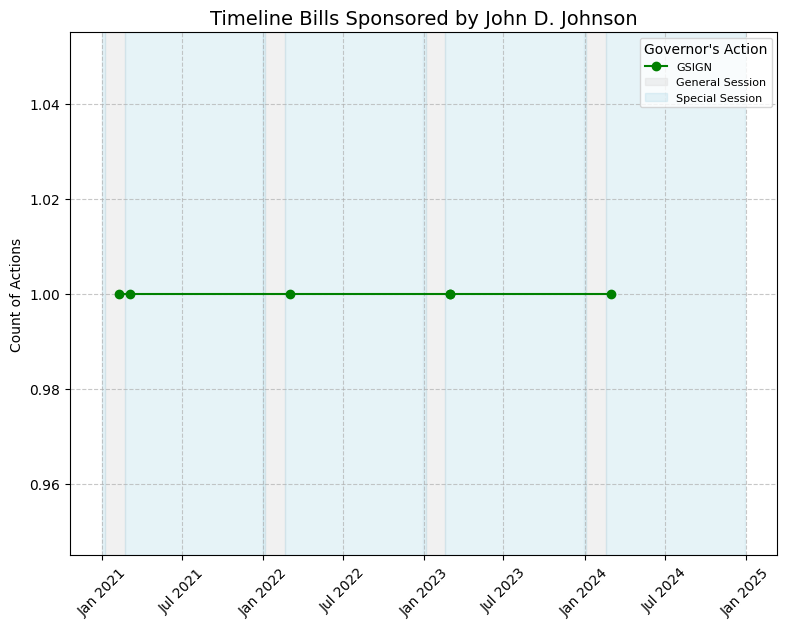

2023-01-05 00:00:00 2023-02-19 00:00:00
2022-01-06 00:00:00 2022-02-20 00:00:00
2021-01-07 00:00:00 2021-02-21 00:00:00
2024-01-04 00:00:00 2024-02-18 00:00:00


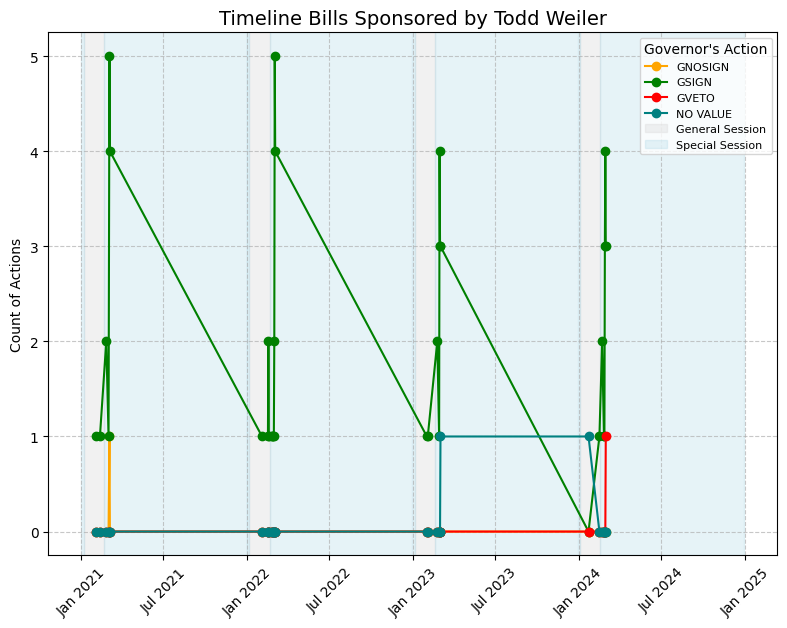

In [43]:
# Now we have the cahrts, lets save the data to a drive so we can use those charts to create a website

# bar chart and timline colors
color_map = {
    'GSIGN': 'green',
    'GVETO': 'red',
    'NO VALUE': 'teal',
    'GOVLVETO': 'blue',
    'GNOSIGN': 'orange',
    None: 'purple'  # Using None for NaN values
}
# category treemap colors
treemap_colormap = {
    'Healthcare': '#FFB11C',
    'Education': '#FF6100',
    'Agriculture & Food': '#85EA00',
    'Government & Administration': '#85EAA8',
    'Environment': '#165EA8',
    'Housing': '#165E65',
    'Technology & Innovation': '#601565',
    'Transportation': '#001565',
    'Economy & Business': '#0015FF',
    'Civil Rights & Justice': '#7DFF74',
    'Military & Defense': '#FFFF7F',
    'Energy': '#FF7AFF',
    'Other': '#402100'
}
# word cloud customization
wordcloud_colors = 'tab20c'
limit_cloud_words = 30
# folder to save charts to
base_drive_path = '/content/drive/My Drive/ut_pol/bill_charts'

# ########### #
# STATE HOUSE #
# ########### #
print('*****************************\nLooping through State House\n*****************************')
state_house = merged_df.loc[merged_df['Office'] == 'State House']

# for candidate in state_house['Name on Ballot'].unique():
#   # Bar Chart #
#   bar_chart_gov_actions(df=state_house,
#                       name_on_ballot=candidate,
#                       color_map=color_map,
#                       print_info=True,
#                       save_chart=True,
#                       show_chart=False)
#   # Timeline #
#   timeline_gov_actions(df=state_house,
#                        name_on_ballot=candidate,
#                        color_map=color_map,
#                        print_info=True,
#                        save_chart=True,
#                        show_chart=False)
#   # Treemap #
#   treemap_bill_categories(df=state_house,
#                         name_on_ballot=candidate,
#                         color_map=treemap_colormap,
#                         print_info=True,
#                         save_chart=True,
#                         show_chart=False)
#   # Wordcloud #
#   wordcloud_bill_titles(df=state_house,
#                         name_on_ballot=candidate,
#                         color_map=wordcloud_colors,
#                         num_words=limit_cloud_words,
#                         base_drive_path=base_drive_path,
#                         show_chart=False,
#                         print_info=True,
#                         save_chart=True)

# ############ #
# STATE SENATE #
# ############ #

print('*****************************\nLooping through State Senate\n*****************************')
state_senate = merged_df.loc[merged_df['Office'] == 'State Senate']

for candidate in state_senate['Name on Ballot'].unique():
  # Bar Chart #
  # bar_chart_gov_actions(df=state_senate,
  #                       name_on_ballot=candidate,
  #                       color_map=color_map,
  #                       print_info=True,
  #                       save_chart=True,
  #                       show_chart=False)
  # Timeline #
  timeline_gov_actions(df=state_senate,
                       name_on_ballot=candidate,
                       color_map=color_map,
                       print_info=False,
                       save_chart=False,
                       show_chart=True)
  # Treemap #
  # treemap_bill_categories(df=state_senate,
  #                         name_on_ballot=candidate,
  #                         color_map=treemap_colormap,
  #                         print_info=True,
  #                         save_chart=True,
  #                         show_chart=False)
  # # Wordcloud #
  # wordcloud_bill_titles(df=state_senate,
  #                     name_on_ballot=candidate,
  #                     color_map=wordcloud_colors,
  #                     num_words=limit_cloud_words,
  #                     base_drive_path=base_drive_path,
  #                     show_chart=False,
  #                     print_info=True,
  #                     save_chart=True)

2023-01-05 00:00:00 2023-02-19 00:00:00
2022-01-06 00:00:00 2022-02-20 00:00:00
2021-01-07 00:00:00 2021-02-21 00:00:00
2024-01-04 00:00:00 2024-02-18 00:00:00


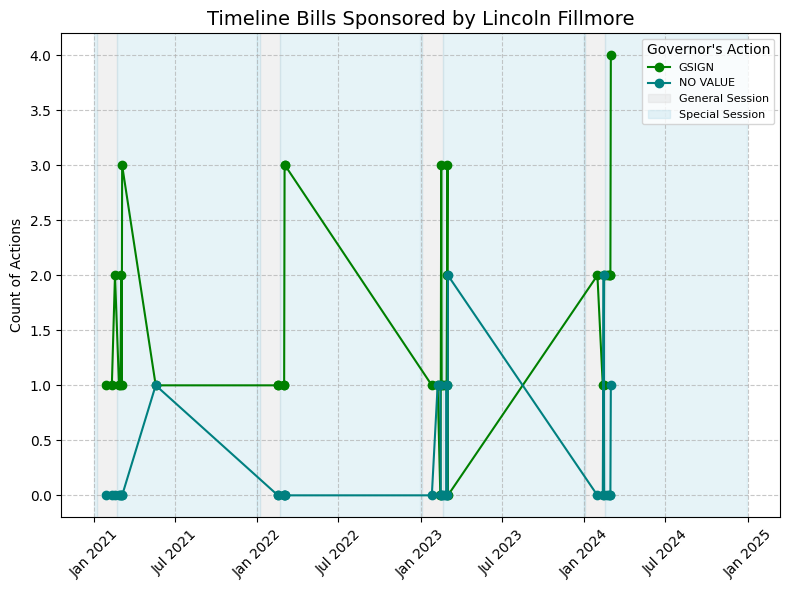

In [33]:
# let's udate the timeline chart to make it more understandable.
# The regular session starts on the 4th monday of January and goes for 45 days.
# if the bills were passed after this it would be in a special session

from datetime import timedelta

name_on_ballot = 'LINCOLN FILLMORE'

df = merged_df.copy()

if df.loc[df['Name on Ballot'] == name_on_ballot].empty:
    print(f"No data found for {name_on_ballot}")

if df.loc[(~df['Bill Number'].isna()) & (df['Name on Ballot'] == name_on_ballot)].empty:
    print(f"No bills found for {name_on_ballot}")

candidate_bills = df[df['Name on Ballot'] == name_on_ballot]
candidate_name = " ".join([x.capitalize() for x in name_on_ballot.split()])
display_district = candidate_bills['Display District'].iloc[0] if not candidate_bills.empty else "N/A"
total_bills = len(candidate_bills)
office = candidate_bills['Office'].iloc[0] if not candidate_bills.empty else "N/A"

candidate_bills['Date Passed'] = pd.to_datetime(candidate_bills['Date Passed'])
timeline_data = candidate_bills.groupby(['Date Passed', 'Governor\'s Action']).size().unstack(fill_value=0)
fig, ax = plt.subplots(figsize=(8, 6))

for action in timeline_data.columns:
    ax.plot(timeline_data.index, timeline_data[action],
            label=action,
            marker='o',
            color=color_map.get(action, 'black'))

ax.set_title(f"Timeline Bills Sponsored by {candidate_name}", fontsize=14)
ax.set_ylabel("Count of Actions")
ax.set_xlabel("")
ax.legend(title='Governor\'s Action', loc='upper right', fontsize=8)
ax.grid(True, linestyle='--', alpha=0.7)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

# Highlighting the General and Special sessions
# Calculate sessions for each year present in the data
years = candidate_bills['Date Passed'].dt.year.unique()

for year in years:
    # Find the fourth Monday in January
    january_first = pd.to_datetime(f"{year}-01-01")
    fourth_monday = january_first + pd.DateOffset(days=(3 - january_first.weekday() + 28) % 7)
    general_session_end = fourth_monday + timedelta(days=45)

    print(fourth_monday, general_session_end)
    # Highlight the General Session period
    ax.axvspan(fourth_monday, general_session_end,
                color='lightgray', alpha=0.3, label='General Session' if year == years.min() else "")

    # Highlight the periods outside of the General Session as Special Session
    if year == years.min():
        ax.axvspan(pd.to_datetime(f"{year}-01-01"), fourth_monday,
                    color='lightblue', alpha=0.3, label='Special Session')
    else:
        ax.axvspan(pd.to_datetime(f"{year}-01-01"), fourth_monday,
                    color='lightblue', alpha=0.3)

    ax.axvspan(general_session_end, pd.to_datetime(f"{year}-12-31"),
                color='lightblue', alpha=0.3)

# Remove duplicate labels in the legend
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys(), title='Governor\'s Action', loc='upper right', fontsize=8)

plt.tight_layout()

plt.show()


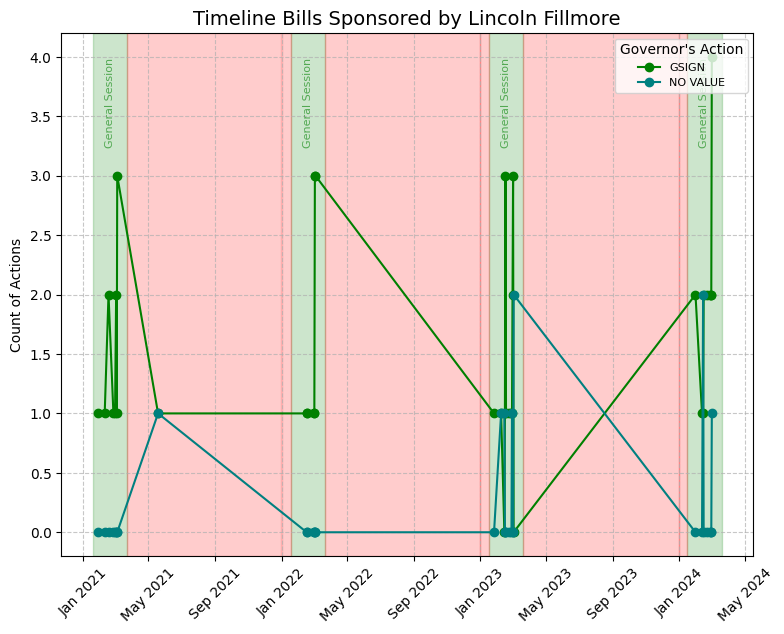

In [40]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

name_on_ballot = 'LINCOLN FILLMORE'

df = merged_df.copy()

candidate_bills = df[df['Name on Ballot'] == name_on_ballot]
candidate_name = " ".join([x.capitalize() for x in name_on_ballot.split()])
display_district = candidate_bills['Display District'].iloc[0] if not candidate_bills.empty else "N/A"
total_bills = len(candidate_bills)
office = candidate_bills['Office'].iloc[0] if not candidate_bills.empty else "N/A"

# Prepare the timeline data
candidate_bills['Date Passed'] = pd.to_datetime(candidate_bills['Date Passed'])
timeline_data = candidate_bills.groupby(['Date Passed', 'Governor\'s Action']).size().unstack(fill_value=0)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot each action as a line on the timeline
for action in timeline_data.columns:
    ax.plot(timeline_data.index, timeline_data[action],
            label=action,
            marker='o',
            color=color_map.get(action, 'black'))

ax.set_title(f"Timeline Bills Sponsored by {candidate_name}", fontsize=14)
ax.set_ylabel("Count of Actions")
ax.set_xlabel("")
ax.legend(title='Governor\'s Action', loc='upper right', fontsize=8)
ax.grid(True, linestyle='--', alpha=0.7)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Define US federal holidays
holidays = calendar().holidays(start=candidate_bills['Date Passed'].min(), end=candidate_bills['Date Passed'].max())

# Determine General Session start and end dates for each year
for year in range(candidate_bills['Date Passed'].dt.year.min(), candidate_bills['Date Passed'].dt.year.max() + 1):
    # Find the 3rd Monday in January
    jan = pd.Timestamp(f'{year}-01-01')
    third_monday = jan + pd.DateOffset(weeks=2, weekday=0)  # 0 = Monday

    # Find the first Tuesday after the third Monday
    start_date = third_monday + pd.DateOffset(weekday=1)  # 1 = Tuesday

    # Calculate the end date, which is 45 weekdays after the start date, excluding holidays
    business_days = pd.bdate_range(start_date, periods=60)  # Create a range longer than 45 to accommodate holidays
    # Remove holiday dates
    general_session_days = [day for day in business_days if day not in holidays][:45]  # Only keep the first 45 days
    end_date = general_session_days[-1] if general_session_days else start_date


    # Add green shading for the General Session period
    ax.axvspan(start_date, end_date, color='green', alpha=0.2)
    mid_point = general_session_days[0] + (general_session_days[-1] - general_session_days[0]) / 2
    ax.text(mid_point, ax.get_ylim()[1] * 0.95, 'General Session',
            ha='center', va='top', fontsize=8, color='green', alpha=0.6, rotation=90)


    # Add red shading for the period before and after the General Session
    if year > candidate_bills['Date Passed'].dt.year.min():
        ax.axvspan(pd.Timestamp(f'{year}-01-01'), start_date, color='red', alpha=0.2)
    if year < candidate_bills['Date Passed'].dt.year.max():
        ax.axvspan(end_date, pd.Timestamp(f'{year}-12-31'), color='red', alpha=0.2)

    # Shade before and after the general session for special sessions
    # ax.axvspan(pd.Timestamp(f'{year}-01-01'), general_session_days[0], color='red', alpha=0.05)
    # ax.axvspan(general_session_days[-1], pd.Timestamp(f'{year}-12-31'), color='red', alpha=0.05)

    # # Add text for the special session area
    # ax.text(general_session_days[0] - pd.Timedelta(days=10), ax.get_ylim()[1] * 0.95, 'Special Session',
    #         ha='center', va='top', fontsize=8, color='red', alpha=0.6, rotation=90)


plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

